<a href="https://colab.research.google.com/github/Running-Machine-ML23-2/problem_3/blob/main/Final_Radom_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

Thanks for 서현, 데이터를 불러올 수 있도록 여러 개로 균등/랜덤하게 나눈 것을 불러옵니다.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pickle
import numpy as np
from collections import Counter

# Load the subsetted pickle file  9500개임
subset_pickle_path = '/content/drive/MyDrive/dataset_/mon_data_sub1.pkl'
with open(subset_pickle_path, 'rb') as f:
    X1, X2, y = pickle.load(f)

# Convert tuples to lists
X1_mon = list(X1) # Array for timestamps
X2_mon = list(X2) # Array for packetsize
y = list(y) # label

outgoing_packets_fraction = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(len(X1_mon)):
    outgoing_packets = 0
    packet_ordering = []
    for j in range(len(X1_mon[i])):
        if X2_mon[i][j] > 0:
            outgoing_packets += 1
            packet_ordering.append(X1_mon[i][j])
    outgoing_packets_fraction.append(outgoing_packets / len(X1_mon[i]))
    std_outgoing_packet_ordering.append(np.std(packet_ordering))


In [10]:
import pickle
import numpy as np

TOTAL_URLS = 3000  # total number in the dataset

print("Loading datafile...")
with open('./drive/MyDrive/dataset_/unmon_data_sub1.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

X1_unmon = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_unmon = [] # Array to store instances (direction*size) - size information
outgoing_packets_fraction_un = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering_un = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    outgoing_packets = 0
    packet_ordering = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512)  # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
        if dr == 1:
            outgoing_packets += 1
            packet_ordering.append(abs(c))
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    outgoing_packets_fraction_un.append(outgoing_packets / len(x[i]))
    std_outgoing_packet_ordering_un.append(np.std(packet_ordering))


Loading datafile...


In [11]:
#Categorical features-3
def cat3_feat(X2):
  in_packet_of_total_packet=[]
  for i in range(len(X2)):
    num_in_pack=0
    for j in range(len(X2[i])):
      if X2[i][j] == -512:
        num_in_pack+=1
    in_packet_of_total_packet.append(num_in_pack/len(X2[i]))
  return in_packet_of_total_packet

# 5.number of outgoing packets
def cat5_feat(X2_mon):
  out_sum=[0]*len(X2_mon)
  for i in range(len(X2_mon)):
    sum=0
    for j in X2_mon[i]:
      if j > 0:
        sum+=1
    out_sum[i]=sum
  return out_sum

cat5_result=cat5_feat(X2_mon)

MAX_SEQUENCE_LENGTH = 100  # 시퀀스의 최대 길이

def pad_sequence(seq, max_length):
    if len(seq) < max_length:
        seq += [0] * (max_length - len(seq))  # 패딩
    else:
        seq = seq[:max_length]  # 잘라냄
    return seq

def compute_bursts(sequence):
    bursts = []
    current_burst = sequence[0]

    for size in sequence[1:]:
        if np.sign(size) == np.sign(current_burst):
            current_burst += size
        else:
            bursts.append(current_burst)
            current_burst = size
    bursts.append(current_burst)
    return bursts

X2_all = X2_mon + X2_unmon

X1_all= X1_mon + X1_unmon

X2_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X2_all]
X1_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X1_all]

X_mon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_mon]
X_unmon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_unmon]
X_bursts_all = X_mon_bursts+X_unmon_bursts

X_mon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_mon]
X_unmon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_unmon]
X_cumsum_all = X_mon_cumsum + X_unmon_cumsum

num_packets = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_mon]
num_packets_un = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_unmon]
X_CAT1 = num_packets+num_packets_un
X_CAT2 = outgoing_packets_fraction+outgoing_packets_fraction_un
X_CAT3 = cat3_feat(X2_mon)+cat3_feat(X2_unmon)
X_CAT4 = std_outgoing_packet_ordering + std_outgoing_packet_ordering_un
X_CAT5 = cat5_feat(X2_mon)+cat5_feat(X2_unmon)

X_CAT1 = np.array(X_CAT1).reshape(-1, 1)
X_CAT2 = np.array(X_CAT2).reshape(-1, 1)
X_CAT3 = np.array(X_CAT3).reshape(-1, 1)
X_CAT4 = np.array(X_CAT4).reshape(-1, 1)
X_CAT5 = np.array(X_CAT5).reshape(-1, 1)

In [12]:
y = y + [-1] * 3000

# Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations
from sklearn.model_selection import train_test_split
import numpy as np

# 피처 목록
features = [X2_all, X1_all, X_bursts_all, X_cumsum_all, X_CAT1, X_CAT2, X_CAT4,X_CAT3,X_CAT5]
feature_names = ['X2_all', 'X1_all', 'X_bursts_all', 'X_cumsum_all', 'X_CAT1', 'X_CAT2', 'X_CAT4','X_CAT3','X_CAT5']

# 결과를 저장할 딕셔너리
results = {}

# 가능한 모든 조합에 대해
for r in range(1, len(features) + 1):
    for subset_indices in combinations(range(len(features)), r):
        subset = [features[i] for i in subset_indices]
        subset_names = [feature_names[i] for i in subset_indices]

        # 피처를 합칩니다
        X = np.concatenate([np.array(feature) for feature in subset], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 모델 초기화
        clf = RandomForestClassifier(random_state=42)

        # 모델 학습
        clf.fit(X_train, y_train)

        # 예측
        y_pred = clf.predict(X_test)

        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)

        # 결과 저장
        results[tuple(subset_names)] = accuracy

# 결과 출력
for subset, accuracy in results.items():
    print("Features: ", subset)
    print("Accuracy: {:.3f}".format(accuracy))


Features:  ('X2_all',)
Accuracy: 0.829
Features:  ('X1_all',)
Accuracy: 0.396
Features:  ('X_bursts_all',)
Accuracy: 0.843
Features:  ('X_cumsum_all',)
Accuracy: 0.842
Features:  ('X_CAT1',)
Accuracy: 0.156
Features:  ('X_CAT2',)
Accuracy: 0.100
Features:  ('X_CAT4',)
Accuracy: 0.069
Features:  ('X_CAT3',)
Accuracy: 0.101
Features:  ('X_CAT5',)
Accuracy: 0.179
Features:  ('X2_all', 'X1_all')
Accuracy: 0.728
Features:  ('X2_all', 'X_bursts_all')
Accuracy: 0.881
Features:  ('X2_all', 'X_cumsum_all')
Accuracy: 0.847
Features:  ('X2_all', 'X_CAT1')
Accuracy: 0.865
Features:  ('X2_all', 'X_CAT2')
Accuracy: 0.865
Features:  ('X2_all', 'X_CAT4')
Accuracy: 0.838
Features:  ('X2_all', 'X_CAT3')
Accuracy: 0.865
Features:  ('X2_all', 'X_CAT5')
Accuracy: 0.866
Features:  ('X1_all', 'X_bursts_all')
Accuracy: 0.746
Features:  ('X1_all', 'X_cumsum_all')
Accuracy: 0.806
Features:  ('X1_all', 'X_CAT1')
Accuracy: 0.444
Features:  ('X1_all', 'X_CAT2')
Accuracy: 0.434
Features:  ('X1_all', 'X_CAT4')
Accur

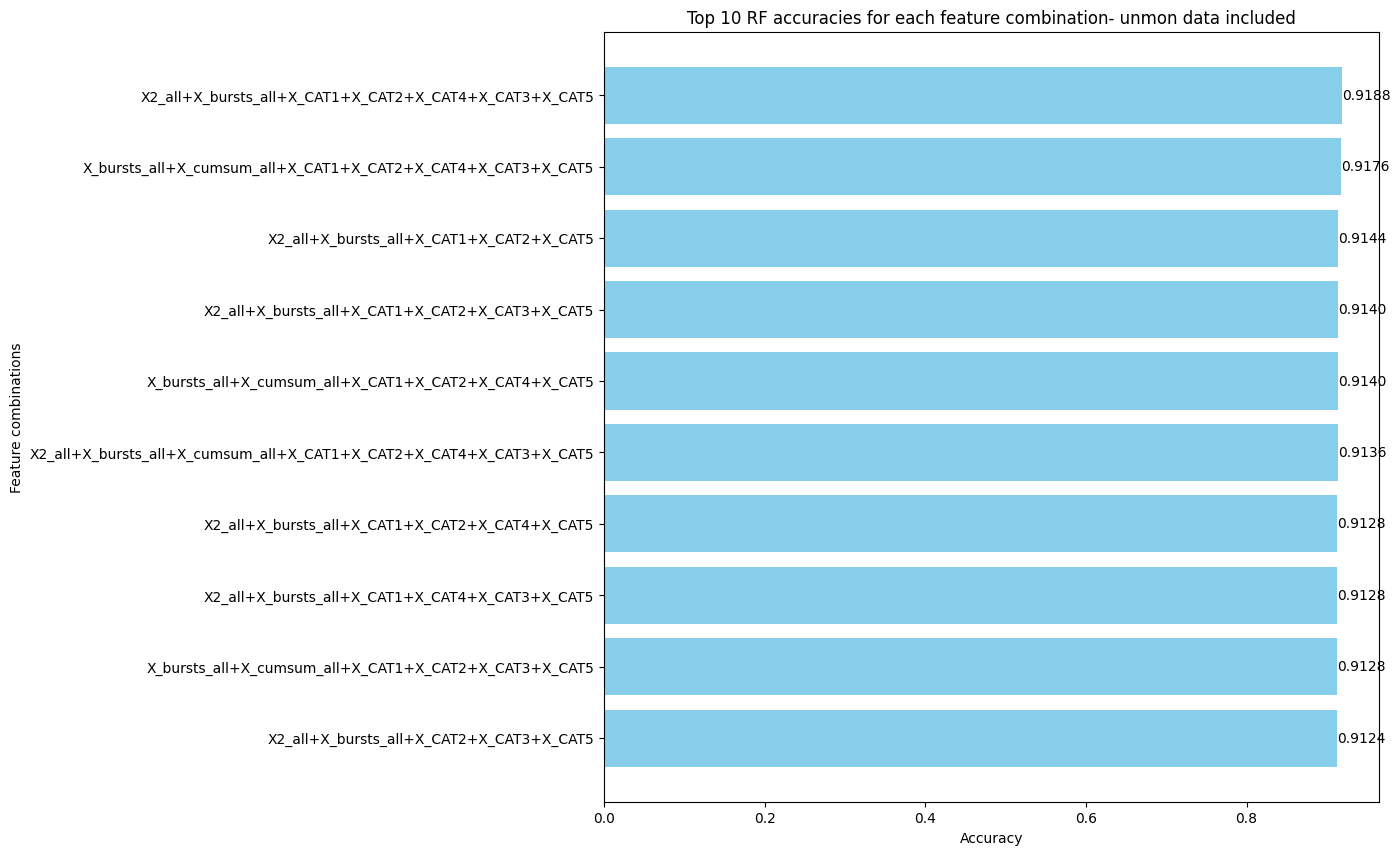

In [7]:
import matplotlib.pyplot as plt

# 결과를 정확도에 따라 내림차순으로 정렬
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

# 상위 10개만 선택
sorted_results = sorted_results[:10]

# 피처 조합과 정확도를 분리
feature_combinations, accuracies = zip(*sorted_results)

# 피처 조합을 문자열로 변환
feature_combinations = ['+'.join(features) for features in feature_combinations]

# 막대 그래프 생성
plt.figure(figsize=(10, 10))
bars = plt.barh(feature_combinations, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Feature combinations')
plt.title('Top 10 RF accuracies for each feature combination- unmon data included')

# 결과값(result)을 막대 옆에 출력
for bar, result in zip(bars, sorted_results):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{result[1]:.4f}', va='center', ha='left')

plt.gca().invert_yaxis()  # y축을 내림차순으로 정렬
plt.show()
